In [178]:
# Added IA representation facilities (indented outline, d3 dendrogram)

# Testing infoscent with slightly more complex IA 
# (all terminals > level 2)

This notebook explores the robustness of the analysis to IA complexification. Outcome seems positive!

In [1]:
import pickle, operator, json, requests

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Natural Language Processing modules
from gensim import corpora, models, similarities, utils
from pattern.en import tag, parse
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import RegexpTokenizer

# Data/Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Machine-learning modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Materials

###GUI IAs

The GUI for this project follows the IA of an on-board computer.

In [3]:
# GUI information architectures (IAs) represented as a nested dictionary

gui4 = {"car":{"air conditioning" : {"increase celsius degrees": "increase celsius degrees","ventilation settings": "ventilation settings", 
                  "recycling mode":"recycling mode"},
               "driving assistance" : {"gps": "gps", 
                                       "lane change alert" : "lane change alert", 
                                      "cruise control": {"activate cruise control":"activate cruise control", 
                                                         "turn off cruise control":"turn off cruise control"}, 
                                      "anti theft notification" :"anti theft notification"}}, 
        "phone": {"dial": "dial","contact list": "contact list", 
                  "check voice mail messages":"check voice mail messages"}, 
        "entertainment": {"play radio": "play radio","television": "television", 
                  "gaming":"gaming"}}

**Easier representations:**
- D3 dendrogram 
- indented outline

In [6]:
# This function generates IA description and syntax for drawing D3 dendrograms

print 'gui = { "name": "home", "children":['
def recurse_dico_keys(dico, indent = '   '):
    for k in dico.keys():
        print indent + '{ "name": "' + str(k) + '",'
        if isinstance(dico[k], dict):
            print indent + '"children":['
            recurse_dico_keys(dico[k], indent + "   ")
        if isinstance(dico[k], str):
            print indent + ' "size": 20},'
    print ']},'
    #print '},'

recurse_dico_keys(gui4)

# For now, must copy/paste output to flask_gui.py and launch server to get:
# Will do a little thingie using boostrap @later

gui = { "name": "home", "children":[
   { "name": "car",
   "children":[
      { "name": "air conditioning",
      "children":[
         { "name": "ventilation settings",
          "size": 20},
         { "name": "recycling mode",
          "size": 20},
         { "name": "increase celsius degrees",
          "size": 20},
]},
      { "name": "driving assistance",
      "children":[
         { "name": "cruise control",
         "children":[
            { "name": "activate cruise control",
             "size": 20},
            { "name": "turn off cruise control",
             "size": 20},
]},
         { "name": "anti theft notification",
          "size": 20},
         { "name": "lane change alert",
          "size": 20},
         { "name": "gps",
          "size": 20},
]},
]},
   { "name": "entertainment",
   "children":[
      { "name": "gaming",
       "size": 20},
      { "name": "television",
       "size": 20},
      { "name": "play radio",
       "size": 20},
]},
   { "name": "pho

<img src="files/D3_gui4.png" width=400 />

In [177]:
# This function translates a nested dictionary in intended outline

def recurse_dico_keys(dico, indent = '   '):
    for k in dico.keys():
        print indent+str(k)
        if isinstance(dico[k], dict):
            recurse_dico_keys(dico[k], indent + '   ')
recurse_dico_keys(gui4)

   car
      air conditioning
         ventilation settings
         recycling mode
         increase celsius degrees
      driving assistance
         cruise control
            activate cruise control
            turn off cruise control
         anti theft notification
         lane change alert
         gps
   entertainment
      gaming
      television
      play radio
   phone
      contact list
      dial
      check voice mail messages


###  Target features, goal descriptions, and their respective familiarity/technicality 

In [8]:
# Function for listing any IA's target features + slots for corresponding goal descriptions and technicality

def list_gui_target_features(gui, g_list = [], h_list = [], u_list = []):
    for k in gui.keys():
        if type(gui[k]) is str:
            g_list.append(gui[k])
            h_list.append('')
            u_list.append('')
        else:
            list_gui_target_features(gui[k])                           
    return zip (g_list, h_list, u_list)

list_gui_target_features(gui4)

[('ventilation settings', '', ''),
 ('recycling mode', '', ''),
 ('increase celsius degrees', '', ''),
 ('activate cruise control', '', ''),
 ('turn off cruise control', '', ''),
 ('anti theft notification', '', ''),
 ('lane change alert', '', ''),
 ('gps', '', ''),
 ('gaming', '', ''),
 ('television', '', ''),
 ('play radio', '', ''),
 ('contact list', '', ''),
 ('dial', '', ''),
 ('check voice mail messages', '', '')]

After running the above function, **practitioner must specify goal descriptions and technicality level for each target feature s/he wants to test.**

***test_set representated as a tuple ('target feature', 'goal description', 'technicality')***

In [4]:
test_set1 = [('ventilation settings', 'change fan speed', 'basic'),
 ('increase celsius degrees', 'increase temperature', 'basic'),
 ('recycling mode', 'prevent exterior air enter', 'technical'),
 ('activate cruise control', 'control my speed', 'technical'),
 ('turn off cruise control', 'disable speed alert', 'technical'),
 ('anti theft notification', 'alert that my car stolen', 'technical'),
 ('lane change alert', 'disable car passing support system', 'technical'),
 ('gps', 'get itinerary parc', 'basic'),
 ('gaming', 'play cards', 'basic'),
 ('play radio', 'lookup classical music broadcast', 'basic'),
 ('television', 'watch favorite tv show', 'basic'),
 ('contact list', 'retrieve my friend mailing address', 'basic'),
 ('dial', 'call number', 'basic'),
 ('check voice mail messages', 'listen recent phone messages', 'basic')]

**Wordnet familiarity as an alternative to subjective technicality labelling:**

In [5]:
#Retrieve basic polysemy proxy from nltk's interface for wordnet

wn_fam = []

for test in test_set1:
    tokenizer = RegexpTokenizer(r'\w+')
    toketxt = tokenizer.tokenize(test[1])
    s = set(stopwords.words('english'))
    filt_wrd = [w for w in toketxt if not w in s]
    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys

    av_polys = float(g_polys)/float(w_count)
    wn_fam.append(round(av_polys, 2))

print sorted(wn_fam)

[3.75, 4.25, 4.5, 5.0, 6.33, 7.25, 7.75, 9.0, 12.33, 13.33, 14.5, 15.0, 29.0, 33.0]


In [7]:
wn_fam_NN = []

for test in test_set1: 
    filt_wrd = []
    g = test[1]
    for w, pos in tag(g): 
        if pos == "NN":
            filt_wrd.append(w)
    print filt_wrd

    w_count = len(filt_wrd)
    g_polys = 0

    for word in filt_wrd:
        w_polys = len(wn.synsets(word))
        g_polys += w_polys
        
    av_polys = float(g_polys)/float(w_count)
    wn_fam_NN.append(round(av_polys, 2))

print sorted(wn_fam_NN) 

[u'change', u'fan', u'speed']
[u'increase', u'temperature']
[u'air', u'enter']
[u'speed']
[u'speed']
[u'car']
[u'car', u'passing', u'support', u'system']
[u'itinerary', u'parc']
[u'play']
[u'lookup', u'music', u'broadcast']
[u'watch', u'tv', u'show']
[u'friend', u'mailing', u'address']
[u'call', u'number']
[u'phone']
[1.5, 3.67, 4.0, 4.5, 5.0, 9.0, 10.0, 10.0, 10.33, 12.0, 12.33, 18.25, 29.0, 52.0]


['target_feat' 'goal' 'counts' 'familiarity' 'wn_familiarity'
 'wn_familiarity_NN' 'model' 'prepping']


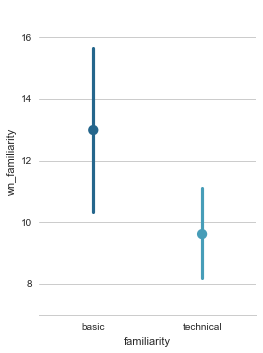

In [17]:
sns.set(style="whitegrid")
print df_gui4.columns.values
g = sns.factorplot(x="familiarity", y="wn_familiarity", data=df_gui4,
                   palette="YlGnBu_d", size=5, aspect=.75)
g.despine(left=True)

Still decent separation!

### Models

In [8]:
# Load tf-idf representation and dictionary mapping for tokenized corpus
wiki = corpora.MmCorpus('latent_tok_tfidf.mm')
mon_dico = corpora.Dictionary.load_from_text('latent_tok_wordids.txt')

# Lemmatized tf-idf representation and dictionary
wiki_lem = corpora.MmCorpus('latent_lem_tfidf.mm')
mon_dico_lem = corpora.Dictionary.load_from_text('latent_lem_wordids.txt')

print "Tokenized corpus:", wiki
print mon_dico, '\n'
print "Lemmatized corpus:", wiki_lem
print mon_dico_lem

Tokenized corpus: MmCorpus(73898 documents, 29597 features, 6418219 non-zero entries)
Dictionary(29597 unique tokens: [u'fawn', u'schlegel', u'sonja', u'woods', u'spiders']...) 

Lemmatized corpus: MmCorpus(59245 documents, 26640 features, 5275674 non-zero entries)
Dictionary(26640 unique tokens: [u'adjust/VB', u'meteor/NN', u'certificate/NN', u'alcatraz/NN', u'removal/NN']...)


In [9]:
# Load model pickles
tok_w2v = models.word2vec.Word2Vec.load("word2vec_tok.model")
lem_w2v = models.word2vec.Word2Vec.load("word2vec_lem.model")
tok_lsi = pickle.load (open ('pickle_lsi.p', 'rb'))
tok_lda = pickle.load (open ('pickle_lda.p', 'rb'))
lem_lsi = pickle.load (open ('pickle_lsi_lem.p', 'rb'))
lem_lda = pickle.load (open ('pickle_lda_lem.p', 'rb'))

## 2. Semantic "sniffing" algorithm

The infoscent method is now applid to the GUI.
The following function takes any state of a GUI, calculates the similarity of each feature in that state with a goal, and returns the features as a list sorted by similarity.


In [10]:
# Needs to know the model type (w2v, w2v_lem, latent, latent_lem)
def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = model.n_similarity(k, goal_v)
            similaritiz[label]=sim          #adding the similarity scores for any label

    # LSI/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):       #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = score
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                              #returns a list of tuples i.e [(,), (,)]


# Check output
print sim_sort(gui4, tok_w2v, 'call your parents', 'w2v'), "\n"
print sim_sort(gui4, lem_lsi, 'call your parents', 'latent_lem'), "\n"
print sim_sort(gui4, tok_lsi, 'call your parents', 'latent'), "\n"

[('phone', 0.31809471697231229), ('car', 0.15134431360520267), ('entertainment', 0.057299009097622436)] 

[('car', -0.0083550652), ('entertainment', -0.0085616298), ('phone', -0.078603856)] 

[('phone', 0.2054445), ('entertainment', -0.011600597), ('car', -0.017856039)] 



This function goes recursively down the GUI, comparing semantic similarity of features in each state with the goal description and following the most familiar down the Information Architecture.

In [11]:
def intermediate_sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    #print state
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = intermediate_sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

#intermediate_sniffer_metrics(gui4, tok, 'cruise control', 'turn off cruise control', 'w2v'), '\n'

## 3. Comparison of model performance

For any goal, this function computes the total number of steps required to "find" the correct target feature. Results are stored for every model type.

In [12]:
def auto_test(test_set, model, model_type):
    test_metrics =[]
    goal_l = []
    target_l=[]
    fam = []
    for a, b, c in test_set:
        goal_l.append(a)
        target_l.append(b)
        fam.append(c)
        result = intermediate_sniffer_metrics(gui4, model, b, a , model_type)
        test_metrics.append(result[1])
    return zip(goal_l, target_l,test_metrics, fam, wn_fam, wn_fam_NN)
    
tok_w2v_test = auto_test(test_set1, tok_w2v, 'w2v')
lem_w2v_test = auto_test(test_set1, lem_w2v, 'w2v_lem')
tok_lsi_test = auto_test(test_set1, tok_lsi, 'latent')
tok_lda_test = auto_test(test_set1, tok_lda, 'latent')
lem_lsi_test = auto_test(test_set1, lem_lsi, 'latent_lem')
lem_lda_test = auto_test(test_set1, lem_lda, 'latent_lem')

Create Pandas dataframes for each model.
Prepare columns for visualizations and model comparison, then concatenate all models into a single dataframe.

In [18]:
df_tok_w2v = pd.DataFrame(tok_w2v_test)
df_tok_w2v['model']='word2vec'
df_tok_w2v['prepping']='tokens'

df_lem_w2v = pd.DataFrame(lem_w2v_test)
df_lem_w2v['model']='word2vec'
df_lem_w2v['prepping']='lemmas'

df_tok_lsi = pd.DataFrame(tok_lsi_test)
df_tok_lsi['model']='lsi'
df_tok_lsi['prepping']='tokens'

df_tok_lda = pd.DataFrame(tok_lda_test)
df_tok_lda['model']='lda'
df_tok_lda['prepping']='tokens'

df_lem_lsi = pd.DataFrame(lem_lsi_test)
df_lem_lsi['model']='lsi'
df_lem_lsi['prepping']='lemmas'

df_lem_lda = pd.DataFrame(lem_lda_test)
df_lem_lda['model']='lda'
df_lem_lda['prepping']='lemmas'

frames = [df_tok_w2v, df_lem_w2v, df_tok_lsi, df_tok_lda, df_lem_lsi, df_lem_lda]
df_gui4=pd.concat(frames)
df_gui4.columns = ['target_feat','goal',  'counts','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

df_gui4.head(5)

,target_feat,goal,counts,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,ventilation settings,change fan speed,4,basic,12.33,12.33,word2vec,tokens
1,increase celsius degrees,increase temperature,3,basic,4.50,4.50,word2vec,tokens
2,recycling mode,prevent exterior air enter,5,technical,7.25,12.00,word2vec,tokens
3,activate cruise control,control my speed,5,technical,14.50,10.00,word2vec,tokens
4,turn off cruise control,disable speed alert,12,technical,6.33,10.00,word2vec,tokens


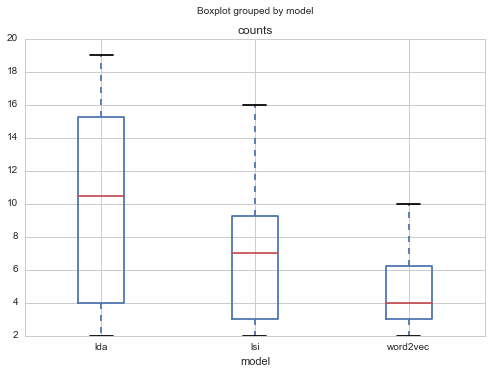

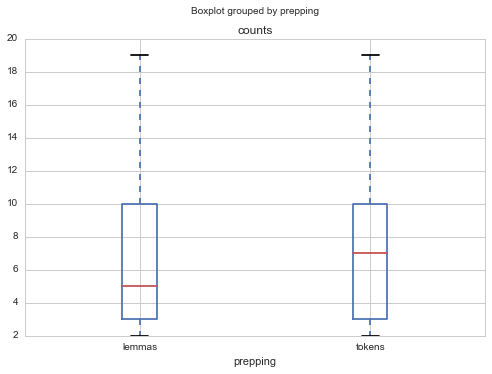

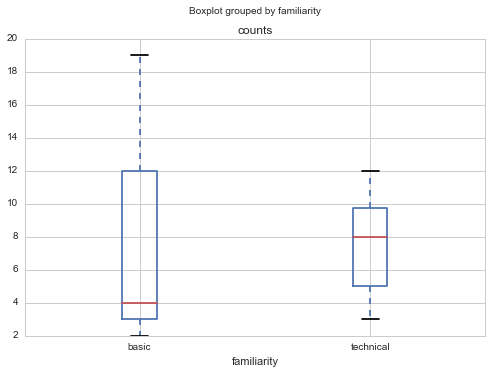

In [19]:
df_gui4.boxplot(column = 'counts', by = 'model')
df_gui4.boxplot(column = 'counts', by = 'prepping')
df_gui4.boxplot(column = 'counts', by = 'familiarity')

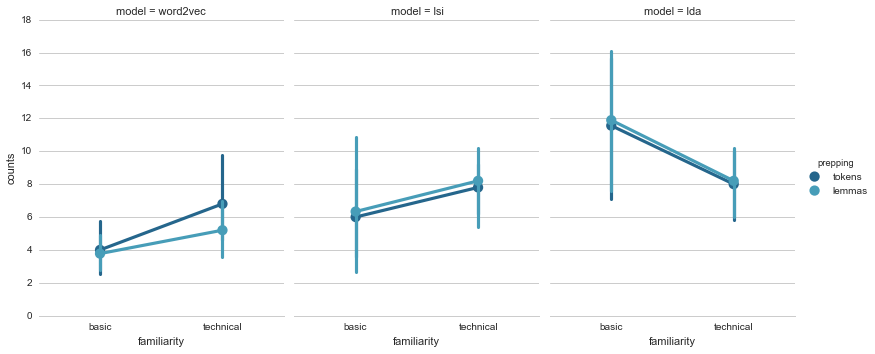

In [20]:
e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=df_gui4,
                   palette="YlGnBu_d", size=5, aspect=.75)
e.despine(left=True)

In [21]:
print df_gui4.columns

anova_1 = ols('counts ~ C(model, Sum)*C(prepping, Sum)*C(familiarity, Sum)',
               data=df_gui4).fit()
table = sm.stats.anova_lm(anova_1, typ=2) # Type 2 ANOVA DataFrame
print table

Index([u'target_feat', u'goal', u'counts', u'familiarity', u'wn_familiarity',
       u'wn_familiarity_NN', u'model', u'prepping'],
      dtype='object')
                                                         sum_sq  df  \
C(model, Sum)                                        478.166667   2   
C(prepping, Sum)                                       0.011905   1   
C(familiarity, Sum)                                    0.222487   1   
C(model, Sum):C(prepping, Sum)                         5.023810   2   
C(model, Sum):C(familiarity, Sum)                    134.381481   2   
C(prepping, Sum):C(familiarity, Sum)                   1.117725   1   
C(model, Sum):C(prepping, Sum):C(familiarity, Sum)     1.968783   2   
Residual                                            1558.666667  72   

                                                            F    PR(>F)  
C(model, Sum)                                       11.044055  0.000066  
C(prepping, Sum)                                     0.0005

### Similarity matrix for Goals and Target features


In [22]:
goal_index = []
for goal in test_set1:
    goal_index.append(goal[1])

sim_heatmap = pd.DataFrame(index=goal_index)

for i, feat in enumerate(test_set1):
    sim_features = []
    for j, goal in enumerate(test_set1):
        sim_features.append(tok_w2v.n_similarity(feat[0].split(), goal[1].split()) )
    sim_heatmap[feat[0]] = sim_features
sim_heatmap.head()

,ventilation settings,increase celsius degrees,recycling mode,activate cruise control,turn off cruise control,anti theft notification,lane change alert,gps,gaming,play radio,television,contact list,dial,check voice mail messages
change fan speed,0.334732,0.350195,0.318533,0.229320,0.409647,0.239094,0.430893,0.272144,0.247755,0.170977,0.065792,0.280180,0.187660,0.271109
increase temperature,0.451423,0.728940,0.408928,0.248899,0.203634,0.116112,0.406705,0.198475,0.018705,-0.071758,-0.089736,0.156829,0.085851,0.079286
prevent exterior air enter,0.348610,0.230782,0.188675,0.452011,0.545227,0.259917,0.334229,0.207439,0.037684,0.104458,0.019115,0.260333,0.143287,0.359290
control my speed,0.283188,0.210514,0.274728,0.414736,0.619212,0.193429,0.338686,0.249979,0.157924,0.205507,0.066804,0.207102,0.167471,0.324617
disable speed alert,0.425650,0.264661,0.410974,0.449580,0.388973,0.352458,0.566966,0.413387,0.235027,0.089045,-0.032025,0.073983,0.198755,0.378668


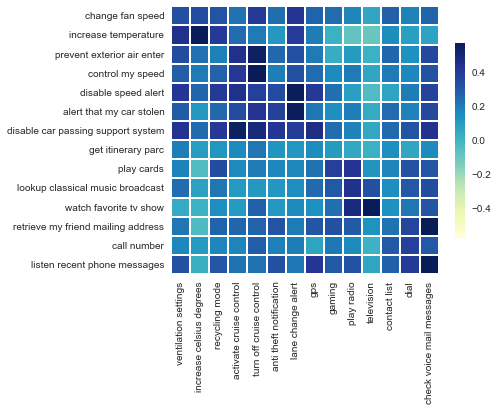

In [23]:
# Plot similarity matrix as heatmap
f, ax = plt.subplots(figsize=(6, 7))

# Draw the heatmap 
sns.heatmap(sim_heatmap,cmap="YlGnBu",
            robust=True,#annot=True,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

## Next steps

- test for normality, if negative revert to non-parametric test 
- tweak model parameters
- compute similarity scores for entire path
- ...